In [28]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = './data/plantvillage/'
print(data_dir)

./data/plantvillage/


In [30]:
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

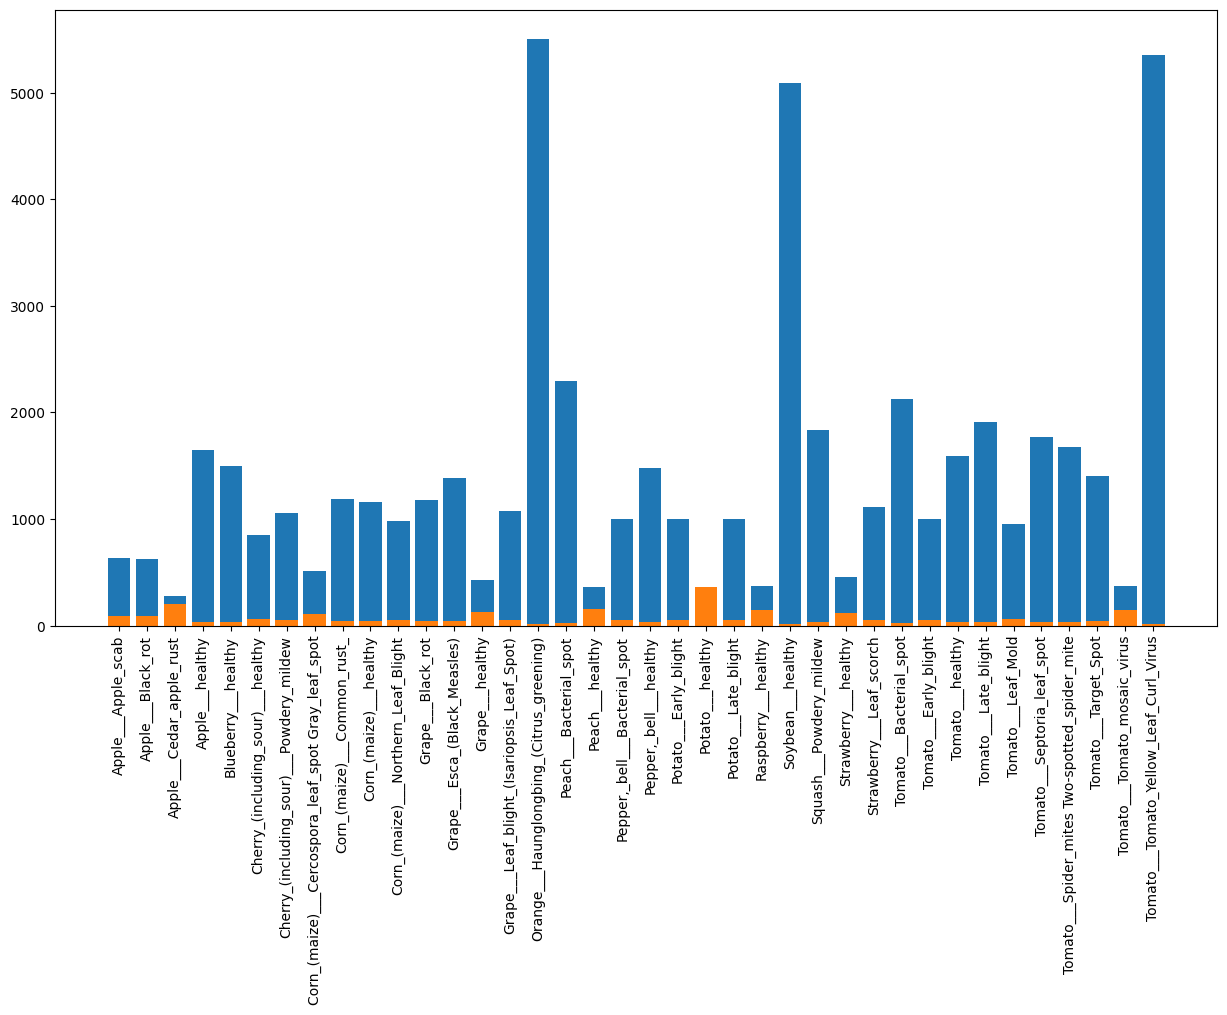

In [31]:
name = []
data_count = []
class_weights = []
total_data = len(image_datasets)
for class_name in os.listdir(data_dir):
    
    all_classes = os.path.join(data_dir, class_name)
    class_len = len(os.listdir(all_classes))
    name.append(class_name)
    data_count.append(class_len)
    weight = 1/(class_len / total_data)
    class_weights.append(weight)
    # print (f"{class_name} --> {class_len}")
plt.figure(figsize=(15,8))
plt.bar(name, data_count)
plt.bar(name, class_weights)
plt.xticks(name, name, rotation='vertical')
plt.show()
class_weights = 1/torch.FloatTensor(class_weights).to(device)
# torch.sum(class_weights)

In [32]:
class_weights

tensor([0.0116, 0.0114, 0.0051, 0.0303, 0.0277, 0.0157, 0.0194, 0.0094, 0.0220,
        0.0214, 0.0181, 0.0217, 0.0255, 0.0078, 0.0198, 0.1014, 0.0423, 0.0066,
        0.0184, 0.0272, 0.0184, 0.0028, 0.0184, 0.0068, 0.0937, 0.0338, 0.0084,
        0.0204, 0.0392, 0.0184, 0.0293, 0.0352, 0.0175, 0.0326, 0.0309, 0.0259,
        0.0069, 0.0986])

In [33]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.8, 0.1, 0.1])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 43445 | No of val: 5430 | No of test: 5430 | 


In [34]:
transform = transforms.ToTensor()
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			x = self.transform(self.dataset[index][0])
		else:
			x = self.dataset[index][0]
		y = self.dataset[index][1]
		return x, y

	def __len__(self):
		return len(self.dataset)

In [35]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class ConvNet(nn.Module):
	def __init__(self):
		super(ConvNet, self).__init__()
		self.fc_dim = 1024
		self.sequential1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential2 = nn.Sequential(
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential3 = nn.Sequential(
			nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.fc = nn.Sequential(
			nn.Linear(self.fc_dim, 120),
			nn.Dropout(0.2),
			nn.Linear(120, 84),      
			nn.Dropout(0.1),
			nn.Linear(84, 38)    
		)   # (n + 2p -f)/s + 1
			
	def forward(self, x):
		out = self.sequential1(x)
		out = self.sequential2(out)
		out = self.sequential3(out)
		out = out.view(-1, self.fc_dim)
		out = self.fc(x)
		return out
	
model = ConvNet().to(device)
# use two gpu
# model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

In [36]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [37]:
train_data = PlantVillageDataset(train, transform)
val_data = PlantVillageDataset(val, transform)
test_data = PlantVillageDataset(test, transform)
x, y = test_data[0]
x, y

(tensor([[[0.5412, 0.6235, 0.5686,  ..., 0.7569, 0.6667, 0.7176],
          [0.5294, 0.5451, 0.5608,  ..., 0.7059, 0.6745, 0.6824],
          [0.5176, 0.4941, 0.5804,  ..., 0.6392, 0.6863, 0.6902],
          ...,
          [0.5922, 0.5373, 0.5373,  ..., 0.6078, 0.6863, 0.6039],
          [0.5569, 0.4863, 0.5020,  ..., 0.6275, 0.6784, 0.6784],
          [0.5098, 0.5020, 0.5451,  ..., 0.6902, 0.5529, 0.6824]],
 
         [[0.5176, 0.6000, 0.5451,  ..., 0.7333, 0.6431, 0.6941],
          [0.5059, 0.5216, 0.5373,  ..., 0.6824, 0.6510, 0.6588],
          [0.4941, 0.4706, 0.5569,  ..., 0.6157, 0.6627, 0.6667],
          ...,
          [0.5686, 0.5137, 0.5137,  ..., 0.5804, 0.6588, 0.5765],
          [0.5333, 0.4627, 0.4784,  ..., 0.6000, 0.6510, 0.6510],
          [0.4863, 0.4784, 0.5216,  ..., 0.6627, 0.5255, 0.6549]],
 
         [[0.5725, 0.6549, 0.6000,  ..., 0.7804, 0.6902, 0.7412],
          [0.5608, 0.5765, 0.5922,  ..., 0.7294, 0.6980, 0.7059],
          [0.5490, 0.5255, 0.6118,  ...,

In [38]:
#hyperparameters
n_input_size = 256*256*3
n_classes = 38
n_epochs = 10
batch_size = 128
learning_rate = 0.01

In [39]:
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [40]:
# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=class_weights, gamma=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(summary(model, batch_dim=batch_size))

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       456
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,416
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       12,832
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
│    └─Linear: 2-10                      123,000
│    └─Dropout: 2-11                     --
│    └─Linear: 2-12                      10,164
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      3,230
Total params: 152,098
Trainable params: 152,098
Non-trainable params: 0


In [41]:
# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # if(epoch + 1) % 10 == 0:
    losses.append(loss.item())
    print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    accuracy = n_correct * 100.0 / n_samples
    print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()